# AI-A2 
## Kasra Ghorbani / 810101489
### Part 1 report


In this part we are to train HMMs using existing libraries of python. The code for this part is presented below :

pandas : used for dataframe managament.
scipy , librosa: used in preprocessing the audio files.
numpy and hmmlearn : used in training the HMMs.
os : used in reading the files from the PC.

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns

### preprocess the data
In this function we use functions and methods from librosa and scipy to preprocess our audio files preparing them for better data extraction. the argument sr is the "sampling rate" meaning the number of samples taken by the audio file in each second. we set it to None so it uses the native frequence of the audio file.

filtered_audio : audio with noise reduction

normalized_audio : the amplitude of the signal is scaled to a target range.

trim : removes silence from the audio so that only meaningful signals remain.

lastly the MFCC coefficients of the audio files are extracted and returned as arguments to be used in training/testing.

In [2]:
def preprocess_and_extract_mfcc(audio, sr):
    filtered_audio = medfilt(audio, kernel_size=3)  # remove noise
    normalized_audio = librosa.util.normalize(filtered_audio)  # normalize
    audio, _ = librosa.effects.trim(normalized_audio)  # remove silence
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # obtain mfcc
    mfccs *= 2
    return audio, mfccs

### Collect data for traning and testing
Here we iterate through each of the 3000 voice samples, collecting 80 percent of them as training samples and the remainder as testing samples. we loop over the folder 40 times and add each audio file to the train data after extracting the digit, speaker name and processing the audio file using the above function. The MFCC matrix is also transposed so that we can later concatenate them in the HMM model training. After 40 iterations we loop over the next 10 files and add them to the test data similiarly. This process is repeated until all files are seen. In the end the two lists for training and testing are converted to dataframes and returned by the function.

In [3]:
def split_train_test_data(folder_path, train_count=40, test_count=10):
    train_data = []
    test_data = []

    filenames = sorted(os.listdir(folder_path))
    total_files = len(filenames)
    idx = 0

    while idx < total_files:
        for _ in range(train_count):
            if idx >= total_files:
                break
            filename = filenames[idx]
            digit_label, speaker_name, _ = filename.split('_')
            file_path = os.path.join(folder_path, filename)
            audio, sr = librosa.load(file_path, sr=None)
            processed_audio, mfccs = preprocess_and_extract_mfcc(audio, sr)
            mfccs = mfccs.T  # transpose mfcc to be able to append
            train_data.append({'Filename': filename,
                               'Digit': digit_label,
                               'Speaker': speaker_name,
                               'MFCCs': mfccs})
            idx += 1

        for _ in range(test_count):
            if idx >= total_files:
                break
            filename = filenames[idx]
            digit_label, speaker_name, _ = filename.split('_')
            file_path = os.path.join(folder_path, filename)
            audio, sr = librosa.load(file_path, sr=None)
            processed_audio, mfccs = preprocess_and_extract_mfcc(audio, sr)
            mfccs = mfccs.T  # transpose mfcc to be able to append
            test_data.append({'Filename': filename,
                              'Digit': digit_label,
                              'Speaker': speaker_name,
                              'MFCCs': mfccs})
            idx += 1

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)

    return train_df, test_df

### Train HMMs.
With this function we train the HMMs. We train 2 different models one for predicting the pronounced digit and one for identification of the speaker. We iterate through our train_data and for each unique digit we read the MFCC values of the audio files related to that specific digit. the MFCC values are then concatenated to all the other MFCC values obtained and fitted into the model. We go through a similiar process to train our model for speaker recognition.The values of n_components and n_iter have been obtained through testing the model with different parameters. The covariance matrix is declared diagonal thus assuming the states to be independent of one another. 

In [4]:
def train_hmm_models(train_df):
    hmm_models_digit = {}
    hmm_models_speaker = {}

    for digit in train_df['Digit'].unique():
        digit_data = train_df[train_df['Digit'] == digit]
        concatenated_data = np.concatenate(digit_data['MFCCs'].values)

        model = hmm.GaussianHMM(
            n_components=20, covariance_type="diag", n_iter=1)
        model.fit(concatenated_data)
        hmm_models_digit[digit] = model

    train_data_by_speaker = {}
    for index, row in train_df.iterrows():
        speaker = row['Speaker']
        mfccs = row['MFCCs']

        if speaker not in train_data_by_speaker:
            train_data_by_speaker[speaker] = []
        train_data_by_speaker[speaker].append(mfccs)

    for speaker, data in train_data_by_speaker.items():
        concatenated_data = np.concatenate(data)

        model = hmm.GaussianHMM(
            n_components=10, covariance_type="diag", n_iter=1)
        model.fit(concatenated_data)
        hmm_models_speaker[speaker] = model

    return hmm_models_digit, hmm_models_speaker

### Test the HMMs.
A function to test our HMM models. this function uses the 2 models to predict the digit and the speaker of the 20% of voice sampled kept for testing. For each digit our model returns a score, a higher score indicating a higher likelihood. the maximum score of all the scores decides what our model will return as its answer. 

In [5]:
def test_hmm_models(test_df, hmm_models_digit, hmm_models_speaker):
    correct_predictions_digit = 0
    total_predictions_digit = 0
    correct_predictions_speaker = 0
    total_predictions_speaker = 0

    for index, row in test_df.iterrows():
        true_digit = row['Digit']
        true_speaker = row['Speaker']
        mfccs = row['MFCCs']

        max_score_digit = float("-inf")
        max_score_speaker = float("-inf")
        predicted_digit = None
        predicted_speaker = None

        # Predict Digit
        for digit, model in hmm_models_digit.items():
            score = model.score(mfccs)
            if score > max_score_digit:
                max_score_digit = score
                predicted_digit = digit

        # Predict Speaker
        for speaker, model in hmm_models_speaker.items():
            score = model.score(mfccs)
            if score > max_score_speaker:
                max_score_speaker = score
                predicted_speaker = speaker

        # Check if the predicted digit matches the true digit label
        if predicted_digit == true_digit:
            correct_predictions_digit += 1
        total_predictions_digit += 1

        # Check if the predicted speaker matches the true speaker label
        if predicted_speaker == true_speaker:
            correct_predictions_speaker += 1
        total_predictions_speaker += 1

    success_rate_digit = (correct_predictions_digit /
                          total_predictions_digit) * 100
    success_rate_speaker = (correct_predictions_speaker /
                            total_predictions_speaker) * 100

    return success_rate_digit, success_rate_speaker

In [6]:
folder_path = r'C:\Users\a\Desktop\recordings'

train_df, test_df = split_train_test_data(folder_path)
hmm_models_digit, hmm_models_speaker = train_hmm_models(train_df)
success_rate_digit, success_rate_speaker = test_hmm_models(
    test_df, hmm_models_digit, hmm_models_speaker)
print(f"Success Rate for digit guess: {success_rate_digit:.2f}%")
print(f"Success Rate for speaker guess: {success_rate_speaker:.2f}%")

Success Rate for digit guess: 91.50%
Success Rate for speaker guess: 85.67%


At the last part we graph the Heatmap for 1 audio file per digit. the heatmap is actually three dimentional with the axes, heat, timeframe, mfcc coefficient. the heatmap shows the db of each mfcc coefficient in different timeframes.  

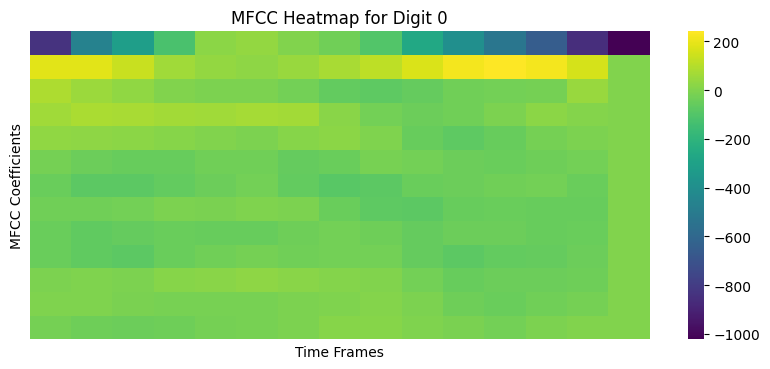

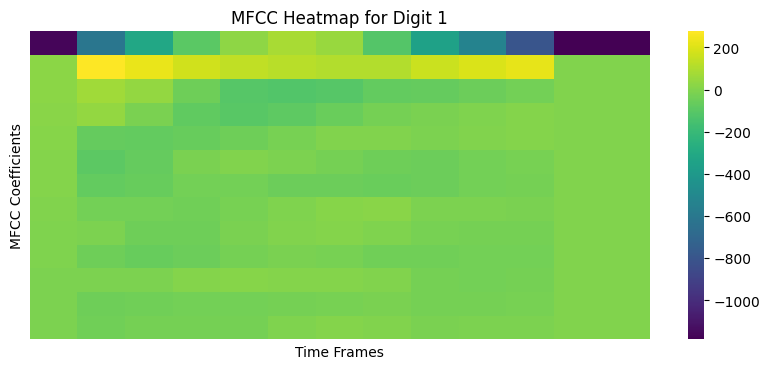

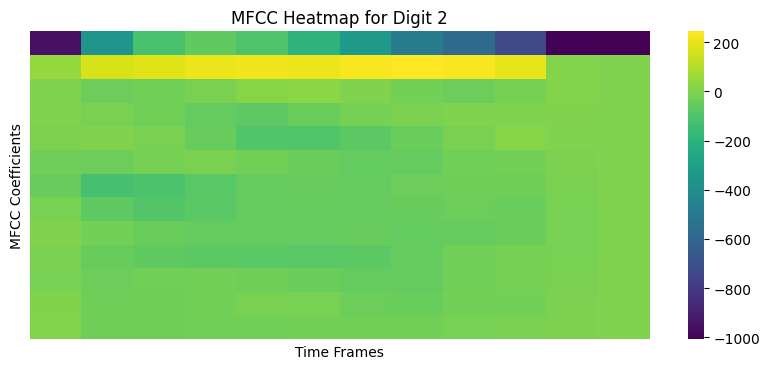

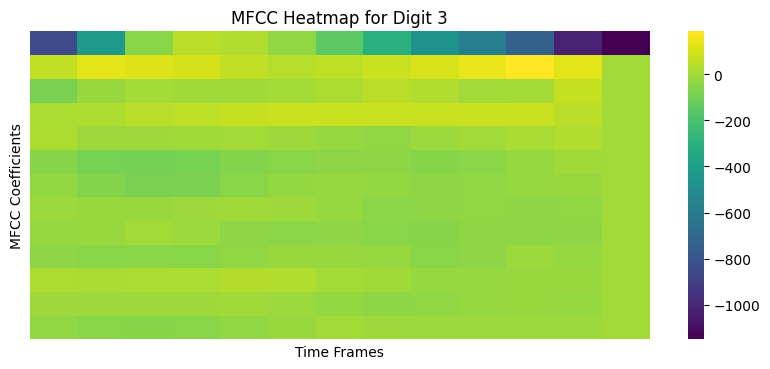

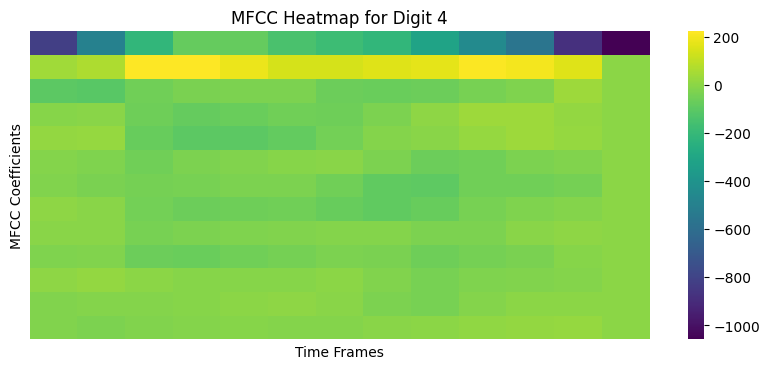

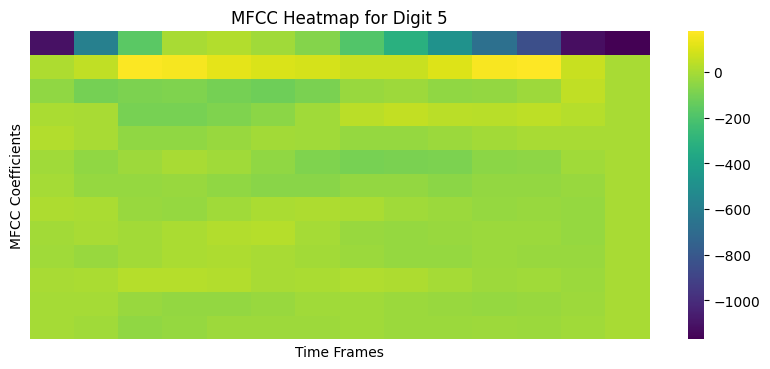

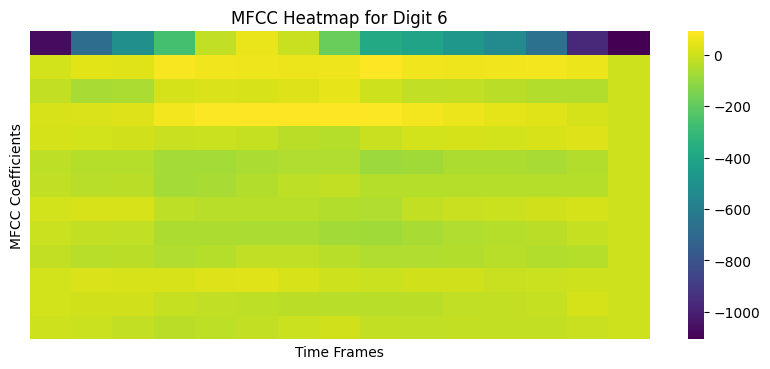

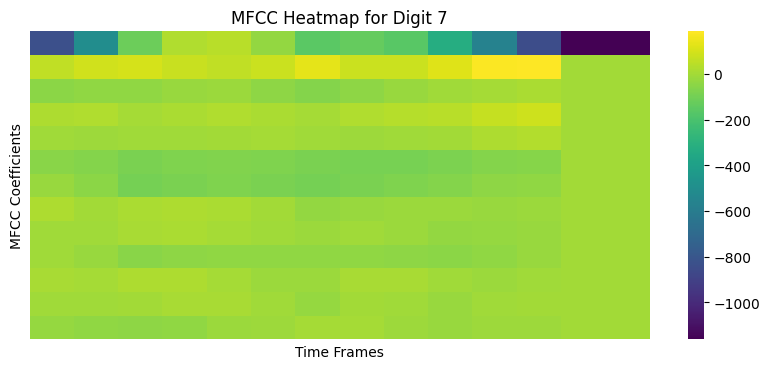

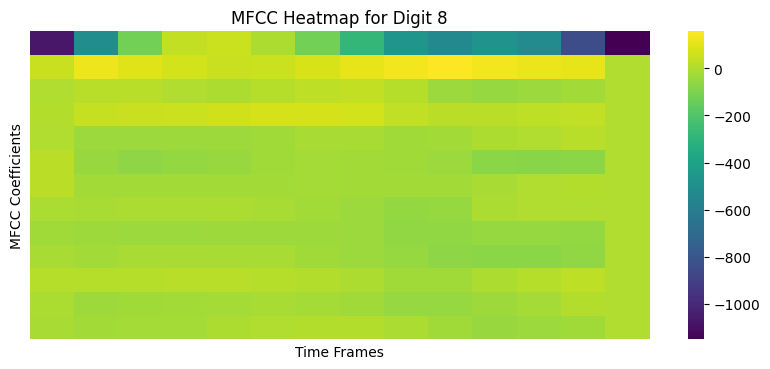

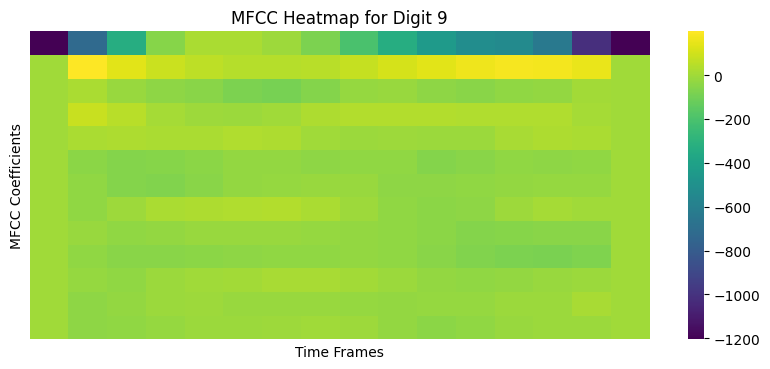

In [7]:
selected_audio_files = {}
for digit in range(10):
    selected_digit_data = test_df[test_df['Digit'] == str(digit)].iloc[0]
    selected_audio_files[digit] = selected_digit_data

for digit, selected_data in selected_audio_files.items():
    mfccs = selected_data['MFCCs']

    plt.figure(figsize=(10, 4))
    sns.heatmap(mfccs.T, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title(f'MFCC Heatmap for Digit {digit}')
    plt.xlabel('Time Frames')
    plt.ylabel('MFCC Coefficients')
    plt.show()